done


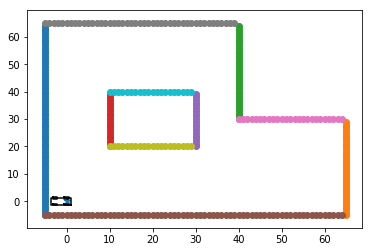

In [7]:
# -*- coding: utf-8 -*-
"""TensorFlow with GPU

Automatically generated by Colaboratory.

Original file is located at
    https://colab.research.google.com/github/sharathsrini/I-m-Here/blob/master/test_test
"""

############PROGRAM STARTS HERE ######################
import numpy as np
import math as MT
from math import floor
import matplotlib.pyplot as plt
import time


###CONSTANTS
#max_angle = 0.785398 #45Deg
#min_angle = -0.785398 #-45Deg

max_angle = 1.0472
min_angle = -1.0472

free_space=0
locked_space=1

### HYPER PARAMETERS
NUMBERS_OF_STEERS=4
STEER_OFFSET=5.0*np.pi/180
LENGTH=4.0
NUM_THETA_CELLS =60

### GRID MAKING 
grid_x_m = 200
grid_y_m = 200

### FOR CELL DIVISION
coll_cell_side = 0.5
grid_on_x = np.int( np.ceil(grid_x_m/coll_cell_side) )
grid_on_y = np.int( np.ceil(grid_y_m/coll_cell_side) )

### FIT ZEROS
GRID_TEST = np.zeros((grid_on_x,grid_on_y),np.int)

### INITIALIZE COST_MAPS AND ASTAR CLOSE MAPS
value_map = np.array([[1000 for x in range(grid_on_x)] for y in range(grid_on_y)])

### MOTION MATRIX FOR ASTAR
motion_mat=np.array([[1,0],[-1,0],[0,-1],[0,1]])



### STATE CLASS
class state:
  def __init__(self,x,y,theta,g,f,h,steer):
    self.x=x
    self.y=y
    self.theta=theta
    self.g=g
    self.f=f
    self.h=h
    self.steer=steer
    
 ## GOAL NODE        
class goal:
    def __init__(self, x, y):
        self.x = x
        self.y = y
        
### INPUT VEHICLE CO-ORDINATES
class vehicle_points():
  def __init__(self,input_co_ordinates,center):
    self.input_co_ordinates=input_co_ordinates
    self.center=center
    
### PATH CLASS FOR TRACKING   
class path():
  def __init__(self,closed,came_from,final):
    self.closed=closed
    self.came_from=came_from
    self.final=final
    

### AUGMENT DELTA +/- GIVEN OFFSET
def delta_augmentation(delta, numbers, offset):
    delta_list = []
    delta_list.append(delta)
    delta_calc_add=delta_calc_sub = delta
    for i in range(0 ,numbers):
        delta_calc_add += offset
        delta_calc_sub -= offset
        if delta_calc_add < max_angle:
            delta_list.append(delta_calc_add)
        if delta_calc_sub > min_angle:
            delta_list.append(delta_calc_sub)
    return delta_list
  


### NEW STATE TRANSITIONS
def new_state_transition(current_state,goal,speed):
    next_states = []
    delta_angles = delta_augmentation( delta=current_state.steer, numbers=NUMBERS_OF_STEERS,offset=STEER_OFFSET)
    DT=1.0/speed
    for delta in delta_angles:
        omega  = (speed / LENGTH) * np.tan(delta)
        theta2 = normalize_theta(current_state.theta + (omega * DT))
        dX = speed * np.cos(theta2) * DT
        dY = speed * np.sin(theta2) * DT
        x2     = current_state.x + dX
        y2     = current_state.y + dY
        g2     = current_state.g + np.sqrt(dX*dX + dY*dY)
        arc_cost=arc_heuristic(goal.x-x2,goal.y-y2,theta2) 
        h2=value_map[idx(x2)][idx(y2)]+arc_cost
        f2     = g2 + h2
        new_state=state(x2,y2,theta2,g2,f2,h2,delta)
        next_states.append(new_state)
    return next_states

### TRANSFORM VEHICLE CO-ORDINATES 
def transform_vehicle_co_ordinates(vehicle_point_object, next_state, angle_of_rotation):
    displaced_matrix = np.array([next_state[0]-vehicle_point_object.center[0],next_state[1]-vehicle_point_object.center[1]])
    transformed_matrix=np.add(vehicle_point_object.input_co_ordinates,displaced_matrix)
    return vehicle_points(rotate_vehicle_co_ordinates(vehicle_points(transformed_matrix,next_state),angle_of_rotation),next_state)
  
  
### ROTATE VEHICLE CO-ORDINATES     
def rotate_vehicle_co_ordinates(vehicle_point_object,angle_of_rotation):
    rotation_matrix = np.array([[np.cos(angle_of_rotation), np.sin(angle_of_rotation)], 
                                [-np.sin(angle_of_rotation), np.cos(angle_of_rotation)]])
    return np.add(vehicle_point_object.center,np.matmul(np.subtract(vehicle_point_object.input_co_ordinates,vehicle_point_object.center), rotation_matrix))
  
  
### CHECK VEHICLE IN SAFE POSITION  
def is_vehicle_in_safe_position(vehicle_point_object,grid):
  for point in vehicle_point_object.input_co_ordinates:
    if(is_within_grid( idx(point[0]),idx(point[1])) and  
       (grid[idx(point[0])][idx(point[1])]==0)):
      continue
    else:
      return False
  return True

### CHK A STAR VEHICLE:
def A_vehicle_is_safe(vehicle_point_A,add_value,grid):
  vp=vehicle_point_A.input_co_ordinates+add_value
  for point in vp:
    if(is_within_grid( idx(point[0]),idx(point[1])) and  
       (grid[idx(point[0])][idx(point[1])]==0)):
      continue
    else:
      return False
  return True
    
    

### EUCLIDEAN DISTANCE
def euclidean_distance(start_point,end_point):
  return np.round(np.sqrt((end_point[0]-start_point[0])**2 +(end_point[1]-start_point[1])**2),4)

### ARC HEURISTIC
def arc_heuristic(x,y,theta_to_be_taken):
  ang_rad=normalize_theta(np.arctan2(y,x))
  diff=np.pi-abs(abs(theta_to_be_taken-ang_rad)-np.pi)
  return diff
  
### NORMALIZE THETA
def normalize_theta(theta):
  if( theta<0 ):
    theta +=( 2*np.pi )
  elif( theta>2*np.pi ):
    theta %=( 2*np.pi)
  return theta

### THETA TO STACK NUMBER
def theta_to_stack_number(theta):
  new = (theta+2*np.pi)%(2*np.pi)
  stack_number = round(new*NUM_THETA_CELLS/2*np.pi)%NUM_THETA_CELLS
  return int(stack_number)

### FLOOR VALUE
def idx(value):
  return int(MT.floor(value))

### CHECK WITHIN GRID  
def is_within_grid(x,y):
  return (x>=0 and x<grid_on_x and y>=0 and y<grid_on_y)

### IS_GOAL_REACHED
def is_goal_reached(start,goal):
  result=False
  if( idx(start[0]) == idx(goal[0]) and idx(start[1])==idx(goal[1])):
    result=True
  return result

### BUILDS THE COST MAP - Here the current state is the goal
def build_cost_map(current_state,goal,grid):
  expand_grid = [[' ' for x in range(grid_on_x)] for y in range(grid_on_y)]
  expand_grid[current_state.x][current_state.y]='*'
  open_list = []
  is_goal_attained=False
  open_list.append(current_state)
  #IMPORTANT
  value_map[current_state.x][current_state.y]=0
  while(len(open_list)>0):
    old_state=open_list.pop(0)
    node=np.array([old_state.x,old_state.y])
    if(goal.x==old_state.x and goal.y==old_state.y):
      is_goal_attained=True
      print("GOAL IS REACHABLE!")
      
    for move in motion_mat:
      nxt_node=node+move
      if( is_within_grid(nxt_node[0],nxt_node[1])):
        if(grid[nxt_node[0]][nxt_node[1]]==0 and expand_grid[nxt_node[0]][nxt_node[1]]!='*'):
          if(A_vehicle_is_safe(vehicle_point_A,np.array([nxt_node]),grid)):
            g2=old_state.g+1
            new_state=state(nxt_node[0],nxt_node[1],0,g2,0,0,0)
            open_list.append(new_state)
            expand_grid[nxt_node[0]][nxt_node[1]]='*'
            value_map[nxt_node[0]][nxt_node[1]]=g2
  return is_goal_attained
            

### SEARCH ALGORITHM
def Hybrid_A_Star(grid,current_state,goal,vehicle_point_object,speed):
  print("STARTED HYBRID A*")
  start_time = time.time()
  closed = np.array([[[free_space for x in range(grid_on_x)] for y in range(grid_on_y)] for cell in range(NUM_THETA_CELLS)])
  came_from = [[[free_space for x in range(grid_on_x)] for y in range(grid_on_y)] for cell in range(NUM_THETA_CELLS)]
  is_goal_attained=False
  stack_number=theta_to_stack_number(current_state.theta)
  closed[stack_number][idx(current_state.x)][idx(current_state.y)]=1
  came_from[stack_number][idx(current_state.x)][idx(current_state.y)]=current_state
  total_closed=1
  opened=[current_state]
  
  while (len(opened)>0):
    opened.sort(key=lambda state_srt : float(state_srt.f))
    state_now=opened.pop(0)
    #print([state_now.x,state_now.y,state_now.theta*np.pi/180])
    if(is_goal_reached([idx(state_now.x),idx(state_now.y)],[idx(goal.x),idx(goal.y)])):
      is_goal_attained=True
      print('GOAL REACHED BY HYBRID A*')
      ret_path=path(closed,came_from,state_now)
      end_time = time.time()
      print(end_time - start_time)
      return (is_goal_attained,ret_path)
    
    for evry_state in new_state_transition(state_now,goal,speed):
      #print('Before',[evry_state.x,evry_state.y,evry_state.theta*np.pi/180])
      if(not is_within_grid(idx(evry_state.x),idx(evry_state.y))):
        continue
      
      stack_num=theta_to_stack_number(evry_state.theta)
      #print([stack_num,idx(evry_state.x),idx(evry_state.y)])
      if closed[stack_num][idx(evry_state.x)][idx(evry_state.y)]==0 and grid[idx(evry_state.x)][idx(evry_state.y)]==0:
        new_vehicle_point_obj = transform_vehicle_co_ordinates(vehicle_point_object,[evry_state.x,evry_state.y],evry_state.theta)
        #print(new_vehicle_point_obj.input_co_ordinates)
        if(is_vehicle_in_safe_position(new_vehicle_point_obj,grid)):
            opened.append(evry_state)
            closed[stack_num][idx(evry_state.x)][idx(evry_state.y)]=1
            came_from[stack_num][idx(evry_state.x)][idx(evry_state.y)]=state_now
            total_closed+= 1
            #print('After',[evry_state.x,evry_state.y,evry_state.theta*np.pi/180])
            #plt.plot([state_now.x,evry_state.x],[state_now.y,evry_state.y])
      #closed[stack_num][idx(evry_state.x)][idx(evry_state.y)]=1
        #print('-------------')
  print('No Valid path')
  ret_path=path(closed,came_from,evry_state)
  return (is_goal_attained,ret_path)



### RECONSTRUCT PATH
def reconstruct_path(came_from, start, final):
    path                 = [(final)]
    stack                = theta_to_stack_number(final.theta)
    current              = came_from[stack][idx(final.x)][idx(final.y)]
    stack                = theta_to_stack_number(current.theta)
    while [idx(current.x), idx(current.y)] != [idx(start[0]), idx(start[1])] :
        path.append(current)
        current              = came_from[stack][idx(current.x)][idx(current.y)]
        stack                = theta_to_stack_number(current.theta)
    return path


###DISPLAY PATH
def show_path(path, start, goal,vehicle_pt_obj_act):
  X=[start[0]]
  Y=[start[1]]
  Theta=[]
  path.reverse()
  X     += [p.x for p in path]
  Y     += [p.y for p in path]
  Theta+=[p.theta for p in path]
  for i in range(len(X)-1):
    Xj=[]
    Yj=[]
    vehicle_pt_obj_now=transform_vehicle_co_ordinates(vehicle_pt_obj_act,[X[i],Y[i]], Theta[i])
    rev=vehicle_pt_obj_now.input_co_ordinates
    revI=rev[:4]
    revL=rev[4:]
    revF=np.concatenate([revI,revL[::-1]])
    l=np.append(revF,[revF[0]],axis=0)
    for i in l:
      Xj.append(i[0])
      Yj.append(i[1])
    plt.plot(Xj,Yj)
  print([np.round(p.steer*180/np.pi,2) for p in path])
  plt.plot(X,Y, color='black')
  plt.scatter([start[0]], [start[1]], color='blue')
  plt.scatter([goal[0]], [goal[1]], color='red')
  plt.show()
  
### PUT OBSTACLES:
def put_obstacles(X_list,Y_list,grid):
  if(len(X_list)>0):
    for i in  X_list:
      x_XO=[]
      x_YO=[]
      for k in range(i[1],i[2]):
        x_XO.append(i[0])
        x_YO.append(k)
        grid[i[0]][k]=1
      plt.scatter(x_XO,x_YO)
  if(len(Y_list)>0):
    for i in Y_list:
      y_XO=[]
      y_YO=[]
      for k in range(i[1],i[2]):
        y_XO.append(i[0])
        y_YO.append(k)
        grid[k][i[0]]=1
      plt.scatter(y_YO,y_XO)

import numpy as np
import matplotlib.pyplot as plt
import math
# Vehicle parameter
W = 2.5 #[m] width of vehicle
LF = 3.7 #[m] distance from rear to vehicle front end of vehicle
LB = 1.0 #[m] distance from rear to vehicle back end of vehicle
TR = 0.5 # Tyre radius [m] for plot
TW = 1.2 # Tyre width [m] for plot
MAX_STEER = 0.6 #[rad] maximum steering angle
WB = 2.7  #[m] wheel base: rear to front steer

def plot_car(x, y, yaw, steer, retrun_car = False):
    car_color = "-k"

    LENGTH = LB+LF

    car_OutLine = np.array([[-LB, (LENGTH - LB), (LENGTH - LB), (-LB), (-LB)],
                             [W / 2, W / 2, - W / 2, - W / 2, W / 2]])


    rr_wheel = np.array([[TR, - TR, - TR, TR, TR],
                         [-W / 12.0 + TW, - W / 12.0 + TW, W / 12.0 + TW, W / 12.0 + TW, - W / 12.0 + TW]])

    rl_wheel = np.array([[TR, - TR, - TR, TR, TR],
                         [-W / 12.0 - TW, - W / 12.0 - TW, W / 12.0 - TW, W / 12.0 - TW, - W / 12.0 - TW]])

    fr_wheel = np.array([[TR, - TR, - TR, TR, TR],
                         [- W / 12.0 + TW, - W / 12.0 + TW, W / 12.0 + TW, W / 12.0 + TW, - W / 12.0 + TW]])

    fl_wheel = np.array([[TR, - TR, - TR, TR, TR],
                         [-W / 12.0 - TW, - W / 12.0 - TW, W / 12.0 - TW, W / 12.0 - TW, - W / 12.0 - TW]])

    Rot1 = np.array([[math.cos(yaw), math.sin(yaw)],
                    [-math.sin(yaw), math.cos(yaw)]])
    Rot2 = np.array([[math.cos(steer), -math.sin(steer)],
                     [math.sin(steer), math.cos(steer)]])


    fr_wheel = np.dot(fr_wheel.T, Rot2).T
    fl_wheel = np.dot(fl_wheel.T, Rot2).T
    fr_wheel[0,:] += WB
    fl_wheel[0,:] += WB
    fr_wheel = np.dot(fr_wheel.T, Rot1).T
    fl_wheel = np.dot(fl_wheel.T, Rot1).T

    car_OutLine = np.dot(car_OutLine.T, Rot1)

    rr_wheel = np.dot(rr_wheel.T, Rot1).T
    rl_wheel = np.dot(rl_wheel.T, Rot1).T

    car_OutLine = car_OutLine.T
    car_OutLine[0,:] += x
    car_OutLine[1,:] += y
    fr_wheel[0, :] += x
    fr_wheel[1, :] += y
    rr_wheel[0, :] += x
    rr_wheel[1, :] += y
    fl_wheel[0, :] += x
    fl_wheel[1, :] += y
    rl_wheel[0, :] += x
    rl_wheel[1, :] += y

    if retrun_car == False:
        plt.plot(x, y, "*")
        plt.plot(fr_wheel[0, :], fr_wheel[1, :], car_color)
        plt.plot(rr_wheel[0, :], rr_wheel[1, :], car_color)
        plt.plot(fl_wheel[0, :], fl_wheel[1, :], car_color)
        plt.plot(rl_wheel[0, :], rl_wheel[1, :], car_color)
        plt.plot(car_OutLine[0, :], car_OutLine[1, :], car_color)
    else:
        return car_OutLine[0, :], car_OutLine[1, :]

plot_car(0.0, 0.0, np.pi, 0.0, retrun_car = False)

#save = 1
def show_animation(path, start, goal,vehicle_pt_obj_act):
  x =[]
  y =[]
  yaw = []
  steer = []
  path.reverse()
  x     += [p.x for p in path]
  y     += [p.y for p in path]
  yaw += [p.theta for p in path]
 
  steer =[p.steer*180/np.pi for p in path]
  print(steer)
  print(type(steer[0]))
  
  for ii in range(0,len(x),5):
      plt.cla()
      plt.plot(x, y, "-b", label="Hybrid A* path")
      common()
      plt.scatter([start[0]], [start[1]], color='blue')
      plt.scatter([goal[0]], [goal[1]], color='red')
      #global save 
      #plt.savefig()
      #save +=1
      plot_car(x[ii], y[ii], yaw[ii], steer[ii])
      plt.grid(True)
      plt.axis("equal")
      plt.pause(0.01)

def search(start,goal_node,present_heading,grid,speed):
    vehicle_pt_obj=transform_vehicle_co_ordinates(vehicle_pt_obj_actual,start,present_heading)
    current_state = state(vehicle_pt_obj.center[0], vehicle_pt_obj.center[1], present_heading, 0.0, 0.0, 0.0,0.0)
    if(build_cost_map(state(goal_node.x,goal_node.y,0,0,0,0,0),goal(start[0],start[1]),grid)):
        process_further,ret_val=Hybrid_A_Star(GRID_TEST,current_state,goal_node,vehicle_pt_obj,speed)
        if(process_further):
            show_animation(reconstruct_path(ret_val.came_from,start,ret_val.final),start,[goal_node.x,goal_node.y],vehicle_pt_obj_actual)
            return True
        else:
            print("GOAL CANT BE REACHED!!")
            return False
    else:
        print("GOAL CANT BE REACHED!!")
        return False

def common():
  #put_obstacles([[10,0,17],[27,0,13],[60,15,35]],[[26,0,30]],GRID_TEST)
  #put_obstacles([[24,0,25],[26,0,25],[27,0,25],[60,15,35]],[],GRID_TEST)
  #put_obstacles([[24,0,25],[26,0,25],[27,0,25],[60,15,35]],[],GRID_TEST)
  #put_obstacles([[1,20,40],[10,25,30],[20,25,30],[30,25,40]],[[40,1,30],[30,10,20]],GRID_TEST)
    #put_obstacles([[0,0,20]],[[20,0,20]],GRID_TEST)
    #put_obstacles([[0,0,20],[10,0,10],[20,20,40],[30,10,40]],[[20,0,20],[10,10,30]],GRID_TEST)
  #put_obstacles([[0,0,20],[10,0,10],[20,20,40],[10,40,50],[57,72,80],[72,10,15],[30,10,40],[20,50,80],[40,50,65],[60,50,65],[40,65,72],[60,50,65], [80,50,80],[90,40,50],[80,20,40],[100,0,20],[80,0,10],[60,10,40]],[[20,0,20],[10,10,30],[40, 30,60],[50,40,60],[40,10,20],[50,10,20], [65,40,60],[80,20,80],[50,80,90],[40,80,90],[20,80,100],[10,60,80],[35,60,70],[55,60,65],[40,40,50],[30,50,60]],GRID_TEST)
    put_obstacles([[-5,-5,65],[65,-5,30],[40,30,65],[10,20,40],[30,20,40]],[[-5,-5,65],[30,40,65],[65,-5,40],[20,10,30],[40,10,30]],GRID_TEST)
common()
### A STAR VEHICLE POINTS
vehicle_point_A=vehicle_points(np.array([[0,2],[0,1],[0,-1],[0,-2],[1,0],[2,0],[-1,0],[-2,0]]),[0,0])
### HYBRID VEHICLE POINTS
vehicle_pt_obj_actual = vehicle_points( np.array([[0.5,0.5],[0.5,1.5],[0.5,2.5],[0.5,3.5],[1.5,0.5],[1.5,1.5],[1.5,2.5],[1.5,3.5]]),[0,2] )

## CALL SEARCH
#search([25,60],goal(35,60),np.pi/2,GRID_TEST,60)
#print('1')
# search([25,20],goal(25,40),np.pi/4,GRID_TEST,60)
# print('2')
# search([25,40],goal(25,60),np.pi/3,GRID_TEST,60)
# print('3')
# search([25,60],goal(50,70),np.pi/2,GRID_TEST,60)
# print('4')
# #search([40,65],goal(70,50),np.pi/3,GRID_TEST,60)
# print('5')
# search([50,70],goal(70,70),0,GRID_TEST,60)
# print('6')
# search([70,70],goal(75,50),-np.pi/4,GRID_TEST,60)
# print('7')
# search([75,50],goal(75,20),-np.pi/2,GRID_TEST,60)
# print('8')
# search([75,20],goal(82,15),-np.pi/2,GRID_TEST,60)
# print('9')
# search([87,15],goal(90,5),0,GRID_TEST,60)

print('done')


In [19]:
X = []
Y = []
coord = []
with open('global_waypoints_direction.txt','r') as input_data:
    for line in input_data:
        x, y,direc = line.split(' ')
        direc =direc.strip()
        #X.append(float(x) - 130)
        #Y.append(float(y) - 100)
        #print("--",direc,"--")
        if(direc=="N"):
            theta=np.pi/2
        elif(direc=="E"):
            theta=0
        elif(direc=="W"):
            theta=np.pi
        elif(direc=="S"):
            theta=-np.pi/2
        else:
            theta=0
        coord.append([float(x) - 127,float(y) - 97,theta])


#print(coord)

#search(coord[i],goal(int(coord[i+1][0]),int(coord[i+1][1])),np.pi/2,GRID_TEST,60)
 


GOAL IS REACHABLE!
STARTED HYBRID A*
GOAL REACHED BY HYBRID A*
1.8597936630249023
[0.0, 0.0, 0.0]
<class 'float'>


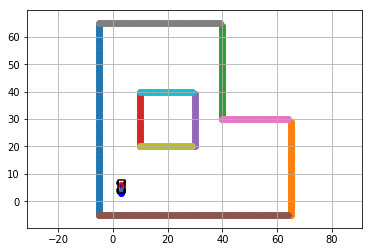

GOAL IS REACHABLE!
STARTED HYBRID A*
GOAL REACHED BY HYBRID A*
1.7621960639953613
[0.0, 0.0, 0.0]
<class 'float'>


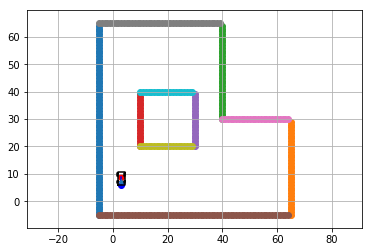

GOAL IS REACHABLE!
STARTED HYBRID A*
GOAL REACHED BY HYBRID A*
1.765441656112671
[0.0, 0.0, 0.0]
<class 'float'>


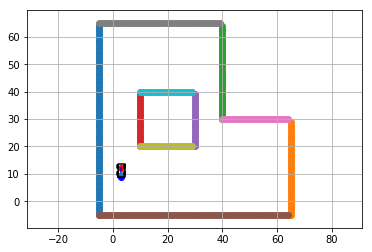

GOAL IS REACHABLE!
STARTED HYBRID A*
GOAL REACHED BY HYBRID A*
1.8679332733154297
[0.0, 0.0, 0.0]
<class 'float'>


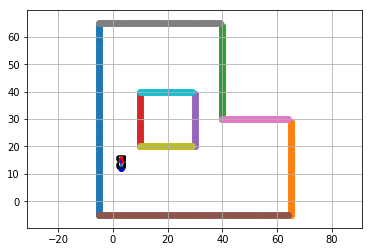

GOAL IS REACHABLE!
STARTED HYBRID A*
GOAL REACHED BY HYBRID A*
1.7397363185882568
[0.0, 0.0, 0.0]
<class 'float'>


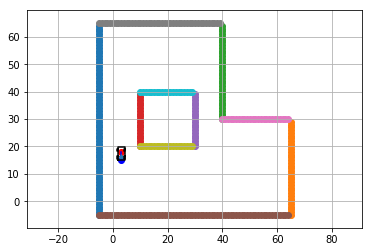

GOAL IS REACHABLE!
STARTED HYBRID A*
GOAL REACHED BY HYBRID A*
1.6975510120391846
[0.0, 0.0, 0.0]
<class 'float'>


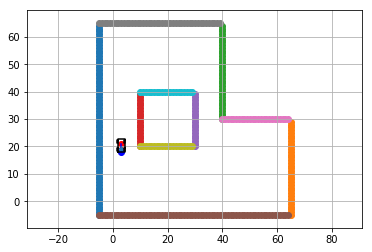

GOAL IS REACHABLE!
STARTED HYBRID A*
GOAL REACHED BY HYBRID A*
1.6930222511291504
[0.0, 0.0, 0.0]
<class 'float'>


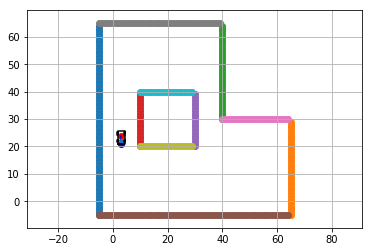

GOAL IS REACHABLE!
STARTED HYBRID A*
GOAL REACHED BY HYBRID A*
1.6480679512023926
[0.0, 0.0, 0.0]
<class 'float'>


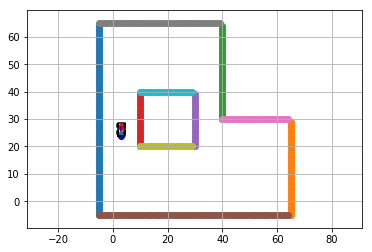

GOAL IS REACHABLE!
STARTED HYBRID A*
GOAL REACHED BY HYBRID A*
1.7383990287780762
[0.0, 0.0, 0.0]
<class 'float'>


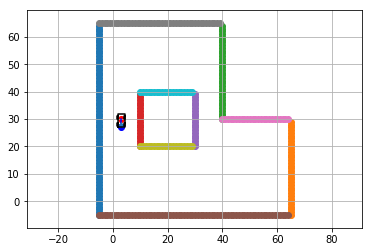

GOAL IS REACHABLE!
STARTED HYBRID A*
GOAL REACHED BY HYBRID A*
1.7142574787139893
[0.0, 0.0, 0.0]
<class 'float'>


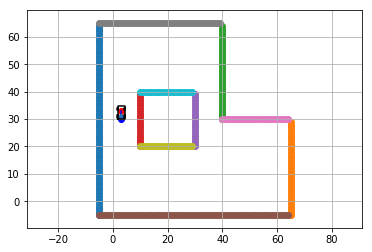

GOAL IS REACHABLE!
STARTED HYBRID A*
GOAL REACHED BY HYBRID A*
1.6428554058074951
[0.0, 0.0, 0.0]
<class 'float'>


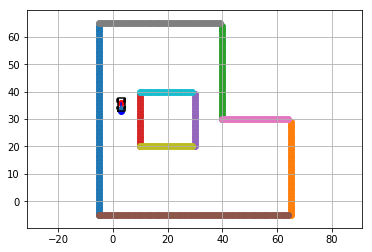

GOAL IS REACHABLE!
STARTED HYBRID A*
GOAL REACHED BY HYBRID A*
1.7350149154663086
[0.0, 0.0, 0.0]
<class 'float'>


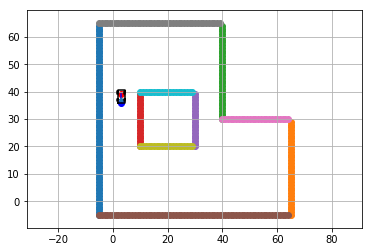

GOAL IS REACHABLE!
STARTED HYBRID A*
GOAL REACHED BY HYBRID A*
1.630164384841919
[0.0, 0.0, 0.0]
<class 'float'>


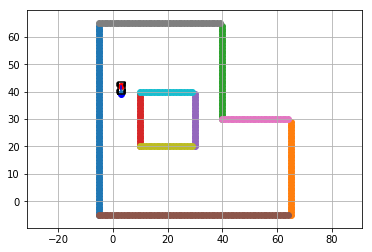

GOAL IS REACHABLE!
STARTED HYBRID A*
GOAL REACHED BY HYBRID A*
1.661299705505371
[0.0, 0.0, 0.0]
<class 'float'>


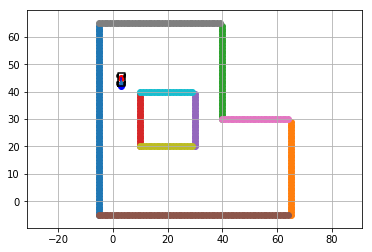

GOAL IS REACHABLE!
STARTED HYBRID A*
GOAL REACHED BY HYBRID A*
1.7034835815429688
[0.0, 0.0, 0.0]
<class 'float'>


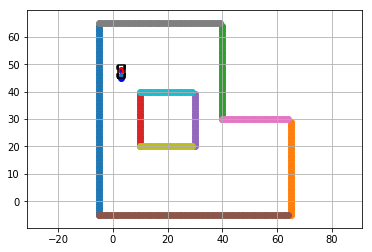

GOAL IS REACHABLE!
STARTED HYBRID A*
GOAL REACHED BY HYBRID A*
1.6661622524261475
[0.0, 0.0, 0.0]
<class 'float'>


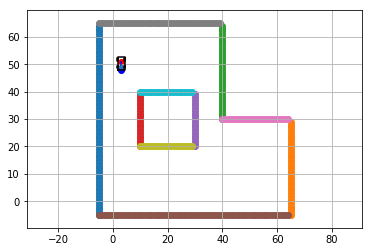

GOAL IS REACHABLE!
STARTED HYBRID A*
GOAL REACHED BY HYBRID A*
1.6875951290130615
[0.0, 0.0, 0.0]
<class 'float'>


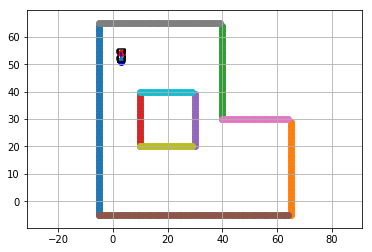

GOAL IS REACHABLE!
STARTED HYBRID A*
GOAL REACHED BY HYBRID A*
1.6840920448303223
[0.0, 0.0, 0.0]
<class 'float'>


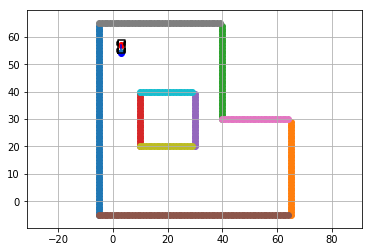

GOAL IS REACHABLE!
STARTED HYBRID A*
GOAL REACHED BY HYBRID A*
1.6558144092559814
[0.0, 0.0, 0.0]
<class 'float'>


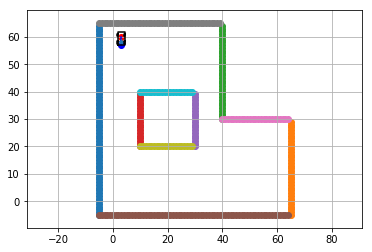

GOAL IS REACHABLE!
STARTED HYBRID A*
GOAL REACHED BY HYBRID A*
1.7025043964385986
[0.0, 0.0, 0.0]
<class 'float'>


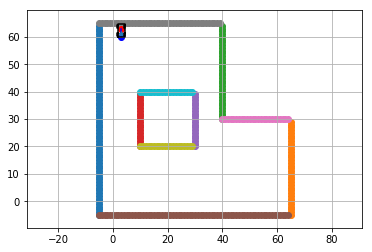

GOAL CANT BE REACHED!!
GOAL IS REACHABLE!
STARTED HYBRID A*
GOAL REACHED BY HYBRID A*
1.749612808227539
[-40.0, -45.0, -24.999999999999996, -4.999999999999995, 15.000000000000005, 10.000000000000005]
<class 'float'>


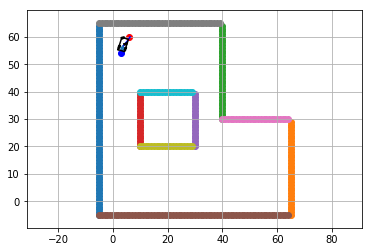

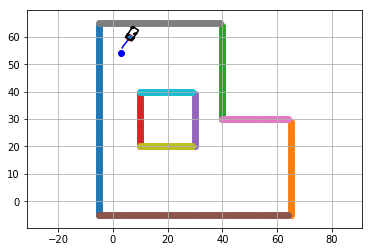

GOAL IS REACHABLE!
STARTED HYBRID A*
GOAL REACHED BY HYBRID A*
1.8208982944488525
[0.0, 0.0, 0.0]
<class 'float'>


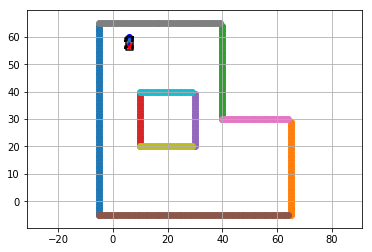

GOAL IS REACHABLE!
STARTED HYBRID A*
GOAL REACHED BY HYBRID A*
1.8368265628814697
[0.0, 0.0, 0.0]
<class 'float'>


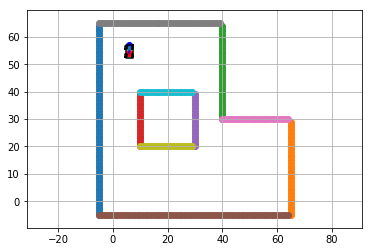

GOAL IS REACHABLE!
STARTED HYBRID A*
GOAL REACHED BY HYBRID A*
1.8391833305358887
[0.0, 0.0, 0.0]
<class 'float'>


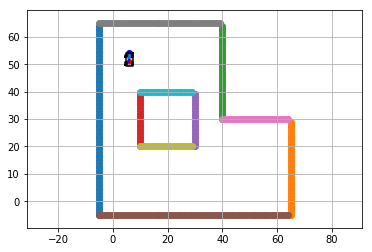

GOAL IS REACHABLE!
STARTED HYBRID A*
GOAL REACHED BY HYBRID A*
1.787400484085083
[0.0, 0.0, 0.0]
<class 'float'>


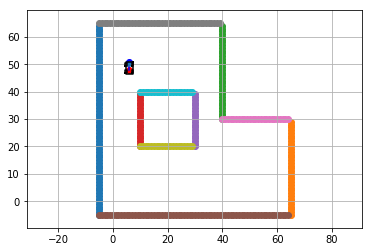

GOAL IS REACHABLE!
STARTED HYBRID A*
GOAL REACHED BY HYBRID A*
1.8038370609283447
[0.0, 0.0, 0.0]
<class 'float'>


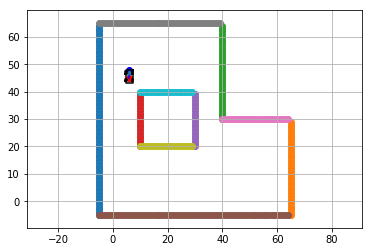

GOAL IS REACHABLE!
STARTED HYBRID A*
GOAL REACHED BY HYBRID A*
1.767066478729248
[0.0, 0.0, 0.0]
<class 'float'>


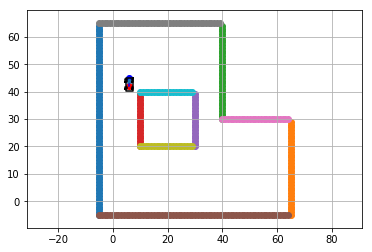

GOAL IS REACHABLE!
STARTED HYBRID A*
GOAL REACHED BY HYBRID A*
1.7483923435211182
[0.0, 0.0, 0.0]
<class 'float'>


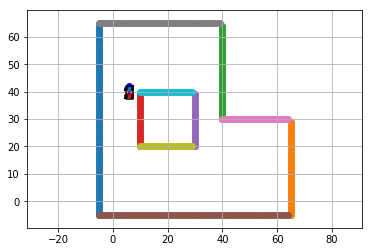

GOAL IS REACHABLE!
STARTED HYBRID A*
GOAL REACHED BY HYBRID A*
1.7702603340148926
[0.0, 0.0, 0.0]
<class 'float'>


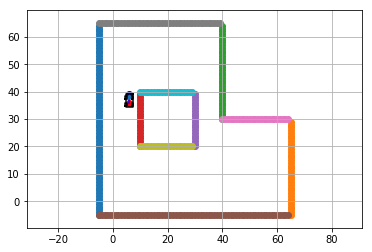

GOAL IS REACHABLE!
STARTED HYBRID A*
GOAL REACHED BY HYBRID A*
1.7890760898590088
[0.0, 0.0, 0.0]
<class 'float'>


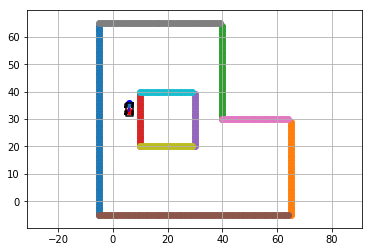

GOAL IS REACHABLE!
STARTED HYBRID A*
GOAL REACHED BY HYBRID A*
1.792428731918335
[0.0, 0.0, 0.0]
<class 'float'>


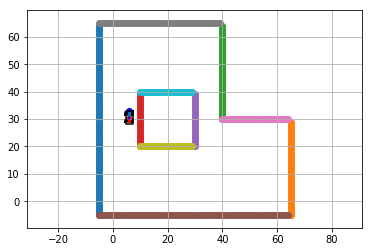

GOAL IS REACHABLE!
STARTED HYBRID A*
GOAL REACHED BY HYBRID A*
1.8070485591888428
[0.0, 0.0, 0.0]
<class 'float'>


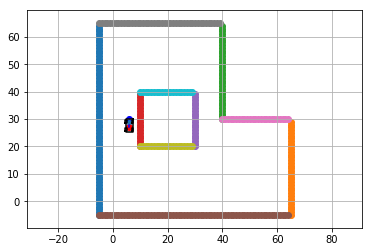

GOAL IS REACHABLE!
STARTED HYBRID A*
GOAL REACHED BY HYBRID A*
1.7775177955627441
[0.0, 0.0, 0.0]
<class 'float'>


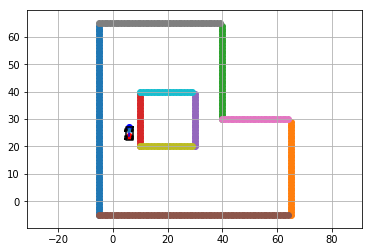

GOAL IS REACHABLE!
STARTED HYBRID A*
GOAL REACHED BY HYBRID A*
1.8195807933807373
[0.0, 0.0, 0.0]
<class 'float'>


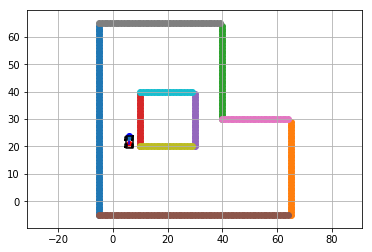

GOAL IS REACHABLE!
STARTED HYBRID A*
GOAL REACHED BY HYBRID A*
1.785456657409668
[0.0, 0.0, 0.0]
<class 'float'>


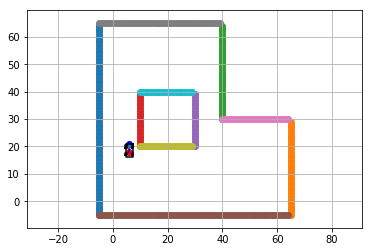

GOAL IS REACHABLE!
STARTED HYBRID A*
GOAL REACHED BY HYBRID A*
1.7024121284484863
[0.0, 0.0, 0.0]
<class 'float'>


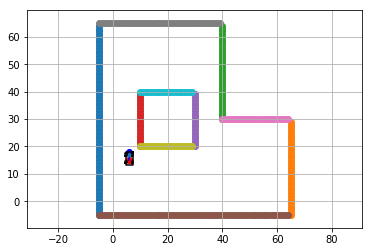

GOAL IS REACHABLE!
STARTED HYBRID A*
GOAL REACHED BY HYBRID A*
1.7178845405578613
[0.0, 0.0, 0.0]
<class 'float'>


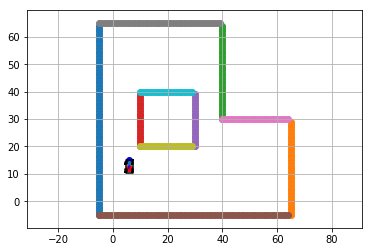

GOAL IS REACHABLE!
STARTED HYBRID A*
GOAL REACHED BY HYBRID A*
1.649977684020996
[0.0, 0.0, 0.0]
<class 'float'>


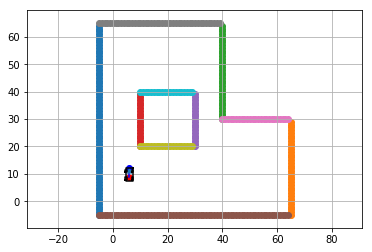

GOAL IS REACHABLE!
STARTED HYBRID A*
GOAL REACHED BY HYBRID A*
1.6639471054077148
[0.0, 0.0, 0.0]
<class 'float'>


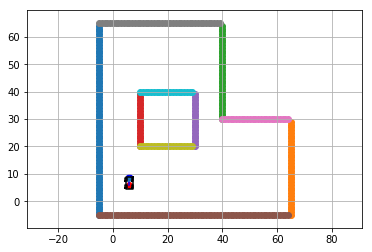

GOAL IS REACHABLE!
STARTED HYBRID A*
GOAL REACHED BY HYBRID A*
1.6874103546142578
[0.0, 0.0, 0.0]
<class 'float'>


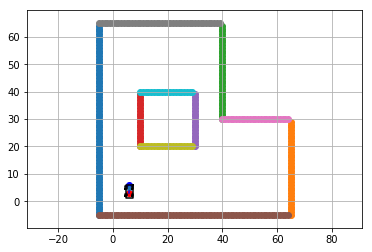

GOAL IS REACHABLE!
STARTED HYBRID A*
No Valid path
GOAL CANT BE REACHED!!
GOAL IS REACHABLE!
STARTED HYBRID A*
GOAL REACHED BY HYBRID A*
1.8660552501678467
[20.0, 40.0, 45.0, 35.0, 14.999999999999996, 4.999999999999995, -5.000000000000004]
<class 'float'>


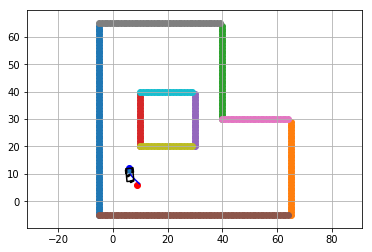

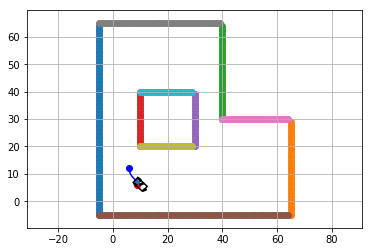

GOAL IS REACHABLE!
STARTED HYBRID A*
GOAL REACHED BY HYBRID A*
1.8190827369689941
[0.0, 0.0, 0.0]
<class 'float'>


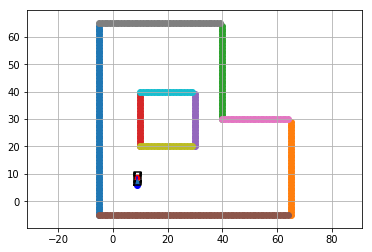

GOAL IS REACHABLE!
STARTED HYBRID A*
GOAL REACHED BY HYBRID A*
1.7420806884765625
[0.0, 0.0, 0.0]
<class 'float'>


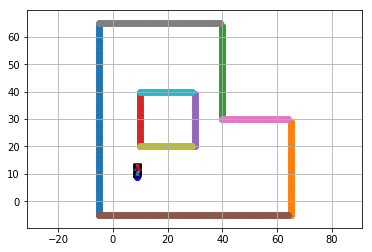

GOAL IS REACHABLE!
STARTED HYBRID A*
GOAL REACHED BY HYBRID A*
1.8199512958526611
[0.0, 0.0, 0.0]
<class 'float'>


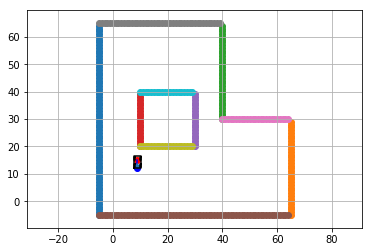

GOAL IS REACHABLE!
STARTED HYBRID A*
GOAL REACHED BY HYBRID A*
1.748755693435669
[0.0, 0.0, 0.0]
<class 'float'>


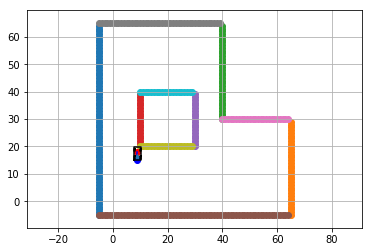

GOAL CANT BE REACHED!!
GOAL CANT BE REACHED!!
GOAL CANT BE REACHED!!
GOAL CANT BE REACHED!!
GOAL CANT BE REACHED!!
GOAL CANT BE REACHED!!
GOAL CANT BE REACHED!!
GOAL CANT BE REACHED!!
GOAL CANT BE REACHED!!
GOAL CANT BE REACHED!!
GOAL CANT BE REACHED!!
GOAL CANT BE REACHED!!
GOAL IS REACHABLE!
STARTED HYBRID A*
GOAL REACHED BY HYBRID A*
1.9894661903381348
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
<class 'float'>


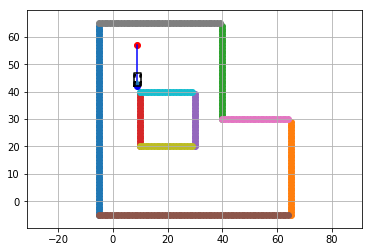

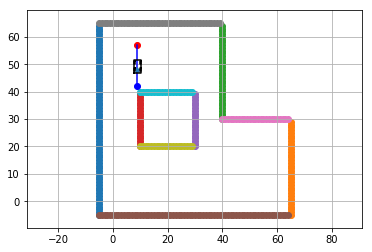

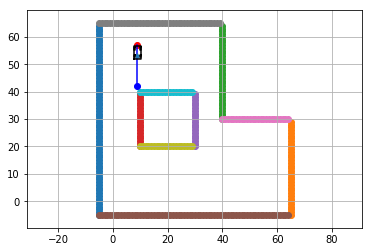

GOAL IS REACHABLE!
STARTED HYBRID A*
GOAL REACHED BY HYBRID A*
1.9340062141418457
[0.0, 0.0, 0.0]
<class 'float'>


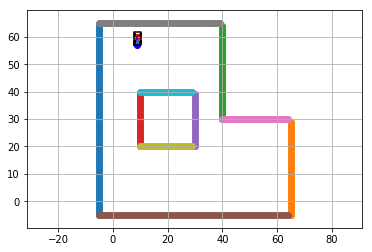

GOAL IS REACHABLE!
STARTED HYBRID A*
GOAL REACHED BY HYBRID A*
1.8550910949707031
[0.0, 0.0, 0.0]
<class 'float'>


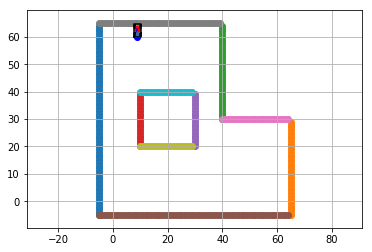

GOAL CANT BE REACHED!!
GOAL IS REACHABLE!
STARTED HYBRID A*
GOAL REACHED BY HYBRID A*
1.768308401107788
[-40.0, -45.0, -24.999999999999996, -4.999999999999995, 15.000000000000005, 10.000000000000005]
<class 'float'>


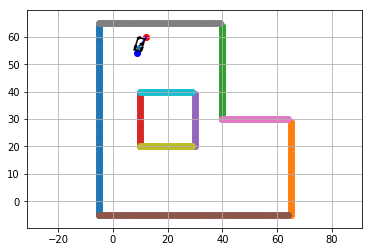

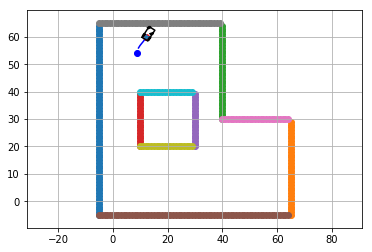

GOAL IS REACHABLE!
STARTED HYBRID A*
GOAL REACHED BY HYBRID A*
1.897623062133789
[0.0, 0.0, 0.0]
<class 'float'>


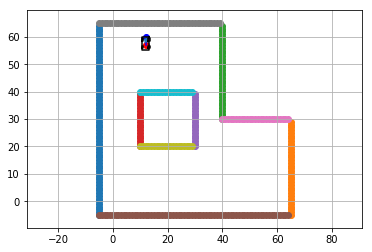

GOAL IS REACHABLE!
STARTED HYBRID A*
GOAL REACHED BY HYBRID A*
1.7545173168182373
[0.0, 0.0, 0.0]
<class 'float'>


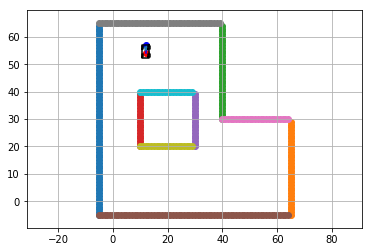

GOAL IS REACHABLE!
STARTED HYBRID A*
GOAL REACHED BY HYBRID A*
1.7008998394012451
[0.0, 0.0, 0.0]
<class 'float'>


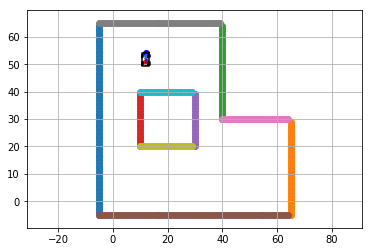

GOAL IS REACHABLE!
STARTED HYBRID A*
GOAL REACHED BY HYBRID A*
1.8063180446624756
[0.0, 0.0, 0.0]
<class 'float'>


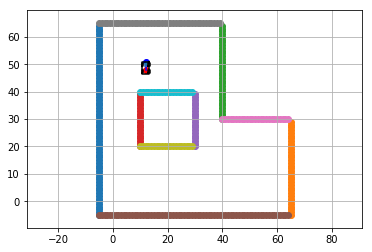

GOAL IS REACHABLE!
STARTED HYBRID A*
GOAL REACHED BY HYBRID A*
1.6548349857330322
[0.0, 0.0, 0.0]
<class 'float'>


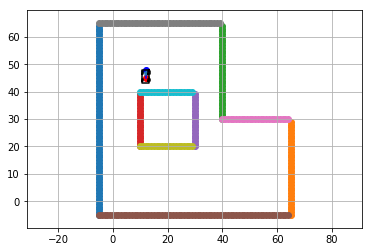

GOAL IS REACHABLE!
STARTED HYBRID A*
GOAL REACHED BY HYBRID A*
1.8235063552856445
[-20.0, -40.0, -45.0, -45.0, -59.99999999999999, -59.99999999999999, -59.99999999999999, -59.99999999999999, -59.99999999999999, -59.99999999999999, -59.99999999999999, -59.99999999999999, -59.99999999999999, -59.99999999999999, -54.99999999999999, -39.99999999999999, -54.99999999999999]
<class 'float'>


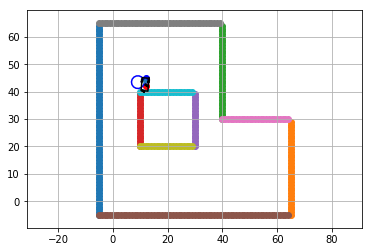

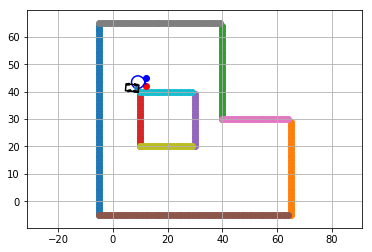

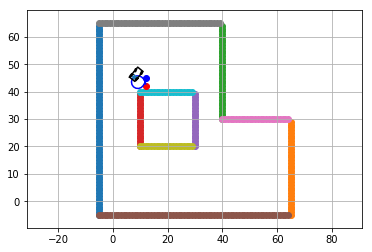

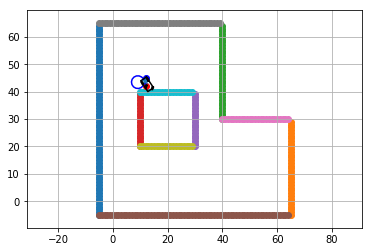

GOAL CANT BE REACHED!!
GOAL CANT BE REACHED!!
GOAL CANT BE REACHED!!
GOAL CANT BE REACHED!!
GOAL CANT BE REACHED!!
GOAL CANT BE REACHED!!
GOAL CANT BE REACHED!!
GOAL CANT BE REACHED!!
GOAL CANT BE REACHED!!
GOAL CANT BE REACHED!!
GOAL CANT BE REACHED!!
GOAL CANT BE REACHED!!
GOAL CANT BE REACHED!!
GOAL IS REACHABLE!
STARTED HYBRID A*
GOAL REACHED BY HYBRID A*
1.6870601177215576
[20.0, 29.999999999999996, 9.999999999999995, 29.999999999999996, 9.999999999999995, 24.999999999999996, 4.999999999999995, -15.000000000000005, -35.0, -55.0, -35.0, -15.000000000000002]
<class 'float'>


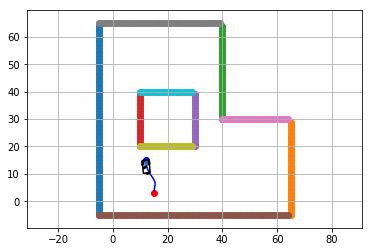

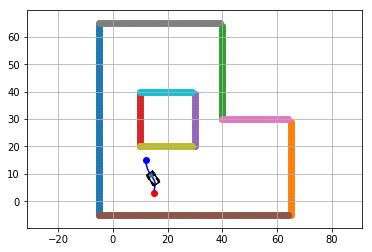

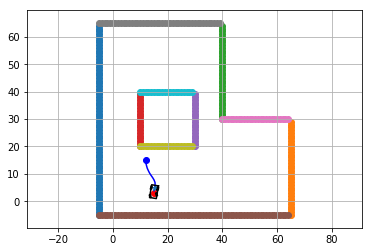

GOAL IS REACHABLE!
STARTED HYBRID A*


In [ ]:
# CALL SEARCH
curr_pos = [coord[0][0],coord[0][1]]
curr_dir = coord[0][2]
next_pos = goal(int(coord[1][0]),int(coord[1][1]))
prev_pos = None

for i in range(len(coord)):
    is_reachable = search(curr_pos,next_pos,curr_dir,GRID_TEST,60)
    if(is_reachable):
        #prev_pos = curr_pos
        curr_pos = [coord[i+1][0],coord[i+1][1]]
        curr_dir = coord[i+1][2]
        next_pos = goal(int(coord[i+2][0]),int(coord[i+2][1]))
    else:
        if(i>3): 
            curr_pos = [coord[i-3][0],coord[i-3][1]]
            curr_dir = coord[i-3][2]
            next_pos = goal(int(coord[i+2][0]),int(coord[i+2][1]))
    
print('done')

#search([2,2],goal(2,19),np.pi/2,GRID_TEST,60)
#search([2,19],goal(2,59),np.pi/2,GRID_TEST,60)
#search([2,45],goal(3,46),np.pi/2,GRID_TEST,20)